In [1]:
import os
import random
import string
from collections import Counter, defaultdict
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
import json


In [2]:
# Define paths
coco_path = '/kaggle/input/coco-2017-dataset/coco2017'
images_path = os.path.join(coco_path, "")
annotations_path = os.path.join(coco_path, 'annotations')

train_images_path = os.path.join(images_path, 'train2017')
val_images_path = os.path.join(images_path, 'val2017')
test_images_path = os.path.join(images_path, 'test2017')

train_annotations_file = os.path.join(annotations_path, 'captions_train2017.json')
val_annotations_file = os.path.join(annotations_path, 'captions_val2017.json')


In [42]:
def load_captions(annotations_file):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    captions = defaultdict(list)
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        caption = ann['caption']
        image_file = f'{image_id:012d}.jpg'
        captions[image_file].append(caption)
    return captions

train_captions = load_captions(train_annotations_file)
val_captions = load_captions(val_annotations_file)
test_captions = load_captions(test_annotations_file)

NameError: name 'test_annotations_file' is not defined

In [4]:
print(len(train_captions))

118287


In [5]:
def clean_caption(caption):
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    caption = ' '.join([word for word in caption.split() if len(word) > 1 and not any(char.isdigit() for char in word)])
    caption = caption.lower()
    return caption

# Clean captions
for image in train_captions:
    train_captions[image] = [clean_caption(caption) for caption in train_captions[image]]

for image in val_captions:
    val_captions[image] = [clean_caption(caption) for caption in val_captions[image]]

In [6]:
# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x[:3, :, :]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x[:3, :, :]),
])


In [37]:
def load_image(image_file, transform):
    image = Image.open(image_file).convert('RGB')
    image = transform(image)
    return image

# Load image function helper
def load_val_image(image_file):
    image = Image.open(image_file).convert('RGB')
    image = val_transform(image)
    return image

In [8]:
word_counter = Counter()
for image, caption_list in train_captions.items():
    for caption in caption_list:
        word_counter.update(caption.split())

vocab_threshold = 5
vocab = [word for word, count in word_counter.items() if count > vocab_threshold]
vocab_size = len(vocab) + 4

# stoi and itos dictionaries for encoding and decoding
stoi = {word: idx + 4 for idx, word in enumerate(vocab)}
stoi['<PAD>'] = 0
stoi['<START>'] = 1
stoi['<END>'] = 2
stoi['<UNK>'] = 3
itos = {idx: word for word, idx in stoi.items()}

In [9]:
len(vocab)

9346

In [16]:
# Helper functions
def encode_caption(caption):
    # Default entry for dictionary.get()
    encoded = [stoi['<START>']] + [stoi.get(word, stoi['<UNK>']) for word in caption.split()] + [stoi['<END>']]
    return encoded

def decode_caption(encoded_caption):
    # Default entry for dictionary.get()
    return ' '.join([itos.get(idx, '<UNK>') for idx in encoded_caption])

def pad_caption(caption, max_length):
    # This actually pads one less than the max, which is not intended. But, we will keep this anyways
    return caption + [stoi['<PAD>']] * (max_length - len(caption))

In [14]:
max_length = max(len(caption.split()) for caption_list in train_captions.values() for caption in caption_list) + 2
max_length

49

In [15]:
# Encodes and pads captions
encoded_train_captions = defaultdict(list)
for image in train_captions:
    for caption in train_captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_train_captions[image].append(padded)

encoded_val_captions = defaultdict(list)
for image in val_captions:
    for caption in val_captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_val_captions[image].append(padded)


In [11]:
def create_sequences(encoded_caption):
    input_sequence = encoded_caption[:-1]
    target_sequence = encoded_caption[1:]
    return input_sequence, target_sequence

# Creates target and train sequences, corresponding to each image, per image
input_train_sequences = defaultdict(list)
target_train_sequences = defaultdict(list)
for image, caption_list in encoded_train_captions.items():
    for caption in caption_list:
        input_seq, target_seq = create_sequences(caption)
        input_train_sequences[image].append(input_seq)
        target_train_sequences[image].append(target_seq)

input_val_sequences = defaultdict(list)
target_val_sequences = defaultdict(list)
for image, caption_list in encoded_val_captions.items():
    for caption in caption_list:
        input_seq, target_seq = create_sequences(caption)
        input_val_sequences[image].append(input_seq)
        target_val_sequences[image].append(target_seq)


In [12]:
def create_batch(caption_dict, input_seq_dict, target_seq_dict, batch_size, image_keys, path):
    images_batch = []
    input_captions_batch = []
    target_captions_batch = []

    for image in image_keys[:batch_size]:
        selected_caption_idx = random.randint(0, len(caption_dict[image]) - 1)
        input_captions_batch.append(input_seq_dict[image][selected_caption_idx])
        target_captions_batch.append(target_seq_dict[image][selected_caption_idx])
        image_path = os.path.join(path, image)  # Adjust this path accordingly
        images_batch.append(load_image(image_path, transform))

    images_batch = torch.stack(images_batch)
    input_captions_batch = torch.tensor(input_captions_batch)
    target_captions_batch = torch.tensor(target_captions_batch)

    return images_batch, input_captions_batch, target_captions_batch

batch_size = 4
train_keys = list(train_captions.keys())
val_keys = list(val_captions.keys())

# Example usage
train_image_batch, train_caption_batch, train_label_batch = create_batch(train_captions, input_train_sequences, target_train_sequences, batch_size, train_keys, train_images_path)
val_image_batch, val_caption_batch, val_label_batch = create_batch(val_captions, input_val_sequences, target_val_sequences, batch_size, val_keys, val_images_path)


Training example:


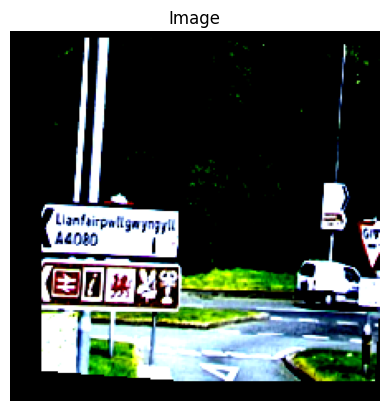

Input Caption: <START> few different road signs are present as van drives along <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: few different road signs are present as van drives along <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Validation example:


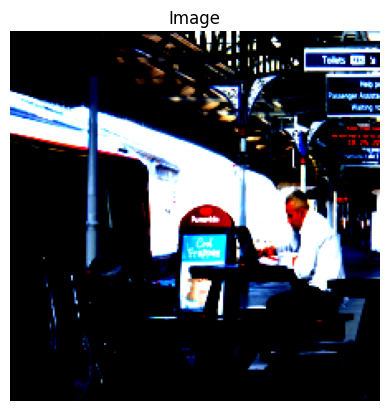

Input Caption: <START> man operates laptop at table in train station <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: man operates laptop at table in train station <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [17]:
def visualize_example(caption_dict, input_seq_dict, target_seq_dict, transform, path):
    random_image = random.choice(list(caption_dict.keys()))
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)

    image_path = os.path.join(path, random_image)  # Adjust this path accordingly
    image_tensor = load_image(image_path, transform)
    image_array = image_tensor.permute(1, 2, 0).numpy()

    input_caption_encoded = input_seq_dict[random_image][caption_idx]
    target_caption_encoded = target_seq_dict[random_image][caption_idx]
    input_caption = decode_caption(input_caption_encoded)
    target_caption = decode_caption(target_caption_encoded)

    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()

    print(f"Input Caption: {input_caption}")
    print(f"Target Caption: {target_caption}")

print("Training example:")
visualize_example(train_captions, input_train_sequences, target_train_sequences, transform, train_images_path)

print("Validation example:")
visualize_example(val_captions, input_val_sequences, target_val_sequences, val_transform, val_images_path)


In [19]:
# Define a residual block for MLP architecture
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size//2)
        self.norm2 = nn.LayerNorm(input_size//2)
        self.fc2 = nn.Linear(input_size//2, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.act = nn.ELU()

    def forward(self, x):
        x = self.act(self.norm1(x))
        skip = self.fc3(x)
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        return x + skip

In [20]:
class ConvNet(nn.Module):
    def __init__(self, dropout):
        super(ConvNet, self).__init__()
        
        # Load the pretrained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Freeze all the VGG16 layers except the last fully connected layer
        for param in self.vgg16.parameters():
            param.requires_grad = False
        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True
        
        # Add dropout before the final fully connected layer
        self.vgg16.classifier[-1] = nn.Sequential(
            nn.Dropout(dropout),
            self.vgg16.classifier[-1]
        )
    
    def forward(self, inputs):  # (224, 224, 3)
        out = self.vgg16(inputs)
        return out  # (B, 1000)


In [21]:
class Decoder(nn.Module):
    def __init__(self, channels_in, dropout, vocab_size, emb_size, hidden_size, num_layers, num_blocks):
        super(Decoder, self).__init__()
        
        self.convnet = ConvNet(dropout = dropout)

        self.linear = nn.Linear(1000, hidden_size)
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, bias = False, batch_first = True)

        # Residual blocks
        self.blocks = nn.Sequential(*[ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)])

        # Activation function
        self.act = nn.ELU()
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    # Memory in will always be a matrice of zeros
    def forward(self, images, captions, mem_in):

        features = self.convnet(images) # (B, 4096)
        features = self.linear(features) # (B, hidden_size)
        features = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1) # (num_layers, B, hidden_size)

        batch_size = images.size(0)
        hidden_size = self.lstm.hidden_size
        num_layers = self.lstm.num_layers

        captions = self.embedding(captions)
        
        outputs, (hidden_out, mem_out) = self.lstm(captions, (features, mem_in))
        # x = (B, T, emb_size)
        # hidden_out = (num_layers, B, hidden_size)
        # mem_out = (num_layers, B, hidden_size)

        outputs = self.act(self.blocks(outputs))
        
        return self.fc_out(outputs) 

In [22]:
# UPDATE the model parameters here

device = torch.device(0 if torch.cuda.is_available() else 'cpu')

nepochs = 5

learning_rate = 1e-4

channels_in = 3

dropout = 0.4

vocab_size = len(stoi)

emb_size = 512

hidden_size = 1024

# LSTM layers
num_layers = 2

# ResBlocks
num_blocks = 1

batch_size = 128

max_length = max_length

# Padding 1 less, than the max_length
time_steps = max_length - 1

max_grad_norm = 5.0  # Gradient clipping threshold

In [23]:
model = Decoder(channels_in = channels_in, dropout = dropout, vocab_size = vocab_size, emb_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, num_blocks = num_blocks).to(device)

memory = torch.zeros(num_layers, batch_size, hidden_size, device=device)

optimizer = optim.AdamW([
    {'params': model.linear.parameters()},
    {'params': model.embedding.parameters()},
    {'params': model.lstm.parameters()},
    {'params': model.blocks.parameters()},
    {'params': model.fc_out.parameters()}
], lr=learning_rate, weight_decay=1e-4)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

loss_fn = nn.CrossEntropyLoss()

training_loss = []

val_loss = []

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Calculate number of model parameters
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("This model Has %d Parameters, %d Million" % (num_model_params, num_model_params//1e6 ) )

# 154M
# 163M

This model Has 170536366 Parameters, 170 Million


In [25]:
def calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    # Calculate the number of complete batches
    num_complete_batches = len(val_keys) // batch_size
    
    with torch.no_grad():
        for i in range(0, num_complete_batches * batch_size, batch_size):
            batch_keys = val_keys[i:i+batch_size]
            image_batch, caption_batch, label_batch = create_batch(val_captions, input_val_sequences, target_val_sequences, len(batch_keys), batch_keys, val_images_path)
            
            image_batch = image_batch.to(device)
            caption_batch = caption_batch.to(device)
            label_batch = label_batch.to(device)
            
            outputs = model(image_batch, caption_batch, memory)
            outputs = outputs.reshape(-1, vocab_size)
            label_batch = label_batch.reshape(-1)
            
            loss = loss_fn(outputs, label_batch)
            total_loss += loss.item()
            num_batches += 1
    
    average_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    return average_loss

In [59]:
# Training loop
for epoch in range(nepochs):
    print("Training:")
    
    # Shuffle the dataset at the beginning of each epoch (to ensure that for every epoch, the batches created are randomized)
    # We train over epochs to ensure that all data in the training_set is trained over
    random.shuffle(train_keys)
    
    # Training
    model.train()
    epoch_loss = 0
    num_batches = 0

    # Variables to accumulate loss for intervals
    interval_loss = 0
    interval_batches = 0
    print_interval = 50  # Adjust the interval as needed

    # This loop ensures that we always get a batch of batch_size number of elements, and iterate over all examples generated in the batch
    # In every iteration, we augment the image keys to reduce overfitting
    # Calculate the number of complete batches
    num_complete_batches = len(train_keys) // batch_size
    
    for i in range(0, num_complete_batches * batch_size, batch_size):
        batch_keys = train_keys[i:i+batch_size]
        image_batch, caption_batch, label_batch = create_batch(train_captions, input_train_sequences, target_train_sequences, len(batch_keys), batch_keys, train_images_path)

        image_batch = image_batch.to(device)
        caption_batch = caption_batch.to(device)
        label_batch = label_batch.to(device)
        
        outputs = model(image_batch, caption_batch, memory)
        outputs = outputs.reshape(-1, vocab_size)
        label_batch = label_batch.reshape(-1)
        
        loss = loss_fn(outputs, label_batch)
        epoch_loss += loss.item()
        interval_loss += loss.item()
        num_batches += 1
        interval_batches += 1

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        # Print average loss every 'print_interval' batches
        if interval_batches == print_interval:
            avg_interval_loss = interval_loss / interval_batches
            print(f"Epoch {epoch+1}, Batch {i//batch_size+1}/{num_complete_batches}, AVG Interval Loss: {avg_interval_loss:.4f}")
            interval_loss = 0
            interval_batches = 0

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / num_batches
    training_loss.append(avg_train_loss)

    # Validation
    model.eval()
    print("Evaluating:")
    
    val_epoch_loss = calculate_average_val_loss(model, val_captions, input_val_sequences, target_val_sequences, batch_size, loss_fn)
    val_loss.append(val_epoch_loss)

    # Print epoch results
    print(f"Epoch {epoch+1}/{nepochs}, AVG Train Loss: {avg_train_loss:.4f}, AVG Val Loss: {val_epoch_loss:.4f}")

    # Update learning rate
    lr_scheduler.step()

Training:


KeyboardInterrupt: 

In [28]:
val_epoch_loss = calculate_average_val_loss(model, val_captions, input_val_sequences, target_val_sequences, batch_size, loss_fn)
val_loss.append(val_epoch_loss)

# Print epoch results
print(f"Epoch {epoch+1}/{nepochs}, AVG Train Loss: {avg_train_loss:.4f}, AVG Val Loss: {val_epoch_loss:.4f}")

# Update learning rate
lr_scheduler.step()

Epoch 1/5, AVG Train Loss: 0.8660, AVG Val Loss: 0.6971


In [102]:
# Save the entire model
torch.save(model.state_dict(), 'lstm-coco2017-image-captioning.pth')


----
----
----
----
----
Random Image: 000000283318.jpg


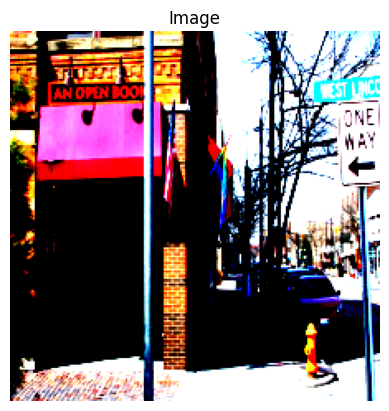

Original Caption: <START> fire hydrant and some cars on the side of the street <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: gentleman getting of bicycles with cars parked next to street <END>
BLEU-1 Score: 0.0126
BLEU-4 Score: 0.0016
Generated Caption: motorcyclist sign on the street corner showing the street ones down street <END>
BLEU-1 Score: 0.0260
BLEU-4 Score: 0.0037
Generated Caption: street sign sits on street with lot of colorful buildings <END>
BLEU-1 Score: 0.0126
BLEU-4 Score: 0.0009
Generated Caption: large sign and blue ancient street sign <END>
BLEU-1 Score: 0.0025
BLEU-4 Score: 0.0002
Generated Caption: city store has stop sign out in small setting <END>
BLEU-1 Score: 0.0022
BLEU-4 Score: 0.0005
Random Image: 000000277689.jpg


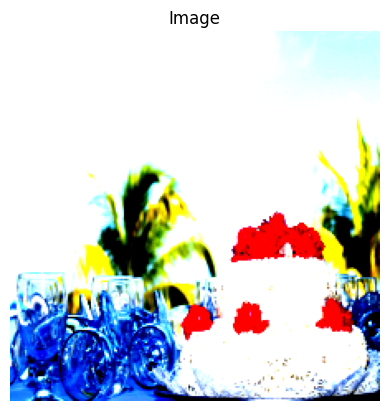

Original Caption: <START> small two tier wedding cake is <UNK> with red flowers on table with <UNK> artfully arranged <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: filled with bunch of donuts on plates <END>
BLEU-1 Score: 0.0025
BLEU-4 Score: 0.0002
Generated Caption: plate of women having table arranged zucchini packing together <END>
BLEU-1 Score: 0.0067
BLEU-4 Score: 0.0006
Generated Caption: plant colored spoons out on the counter <END>
BLEU-1 Score: 0.0017
BLEU-4 Score: 0.0002
Generated Caption: teddy fruits sits on wooden beach <END>
BLEU-1 Score: 0.0008
BLEU-4 Score: 0.0001
Generated Caption: dumplings cake is being hung by roses <END>
BLEU-1 Score: 0.0025
BLEU-4 Score: 0.0004
Random Image: 000000229358.jpg


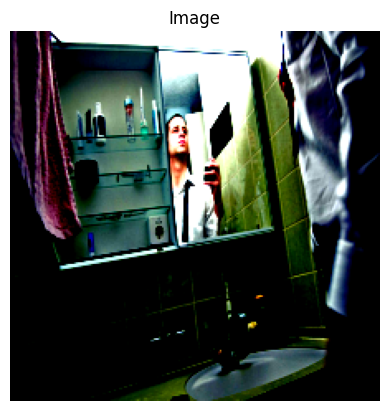

Original Caption: <START> man standing in front of bathroom mirror and sink <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: bathroom with fixtures tub and bath room <END>
BLEU-1 Score: 0.0025
BLEU-4 Score: 0.0002
Generated Caption: small bathroom has tile toilet sink <END>
BLEU-1 Score: 0.0012
BLEU-4 Score: 0.0002
Generated Caption: bathroom with clock sticking mounted outside <END>
BLEU-1 Score: 0.0008
BLEU-4 Score: 0.0001
Generated Caption: bathroom is sink in mirror bathroom <END>
BLEU-1 Score: 0.0020
BLEU-4 Score: 0.0001
Generated Caption: the kitchen has pink only beige holder for the ceiling <END>
BLEU-1 Score: 0.0031
BLEU-4 Score: 0.0007
Random Image: 000000451693.jpg


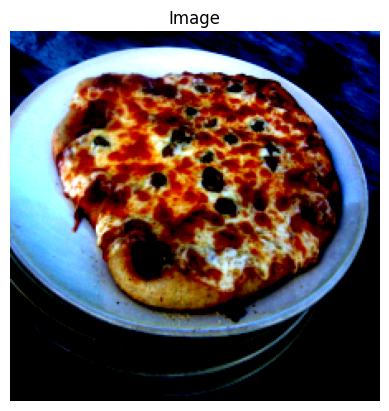

Original Caption: <START> pizza placed on white plate on wooden table <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: pizza that has into mushrooms <END>
BLEU-1 Score: 0.0003
BLEU-4 Score: 0.0000
Generated Caption: bowl of sliced smothered like sandwich <END>
BLEU-1 Score: 0.0004
BLEU-4 Score: 0.0001
Generated Caption: doughnut on top of plate of vegetables at table <END>
BLEU-1 Score: 0.0089
BLEU-4 Score: 0.0012
Generated Caption: pepperoni plate has sausage knacks broccoli and toppings <END>
BLEU-1 Score: 0.0029
BLEU-4 Score: 0.0004
Generated Caption: cake in the kitchen with sauce and plate of eggs and fries <END>
BLEU-1 Score: 0.0104
BLEU-4 Score: 0.0013
Random Image: 000000096960.jpg


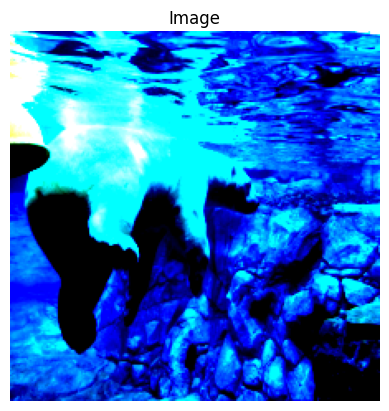

Original Caption: <START> polar bear swimming in the water by wall <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: young adult holds tan out <END>
BLEU-1 Score: 0.0002
BLEU-4 Score: 0.0000
Generated Caption: polar bear swimming by large wave <END>
BLEU-1 Score: 0.0020
BLEU-4 Score: 0.0005
Generated Caption: large polar bear is walking on the ground <END>
BLEU-1 Score: 0.0058
BLEU-4 Score: 0.0008
Generated Caption: brown bear laying down on sandy top sill <END>
BLEU-1 Score: 0.0029
BLEU-4 Score: 0.0004
Generated Caption: polar polar polar bear in the ocean <END>
BLEU-1 Score: 0.0042
BLEU-4 Score: 0.0006


In [77]:
# Sampling functions with BLEU scores only
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def sample_caption(image, max_length=30):
    model.eval()
    
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    features = model.convnet(image.unsqueeze(0).to(device))  # Get features from the image
    features = model.linear(features)  # Transform features to hidden size
    features = features.unsqueeze(0).repeat(num_layers, 1, 1)  # Add time dimension (1, 1, hidden_size)
    
    input_tokens = sos_token  # Start with <sos> token
    generated_caption = []
    
    for _ in range(max_length):
        input_embed = model.embedding(input_tokens)  # Embed the input tokens
        
        output, _ = model.lstm(input_embed, (features, torch.zeros_like(features)))
        
        output = model.blocks(output)
        
        output = model.fc_out(output)  # Output shape: (1, seq_length, vocab_size)
        
        probabilities = F.softmax(output[:, -1, :], dim=-1)
        
        next_token = torch.argmax(probabilities, dim=-1).unsqueeze(0)
        next_token = torch.multinomial(probabilities, num_samples=1)
        
        generated_caption.append(itos[next_token.item()])
        
        input_tokens = torch.cat([input_tokens, next_token], dim=1)

        if next_token.item() == stoi['<END>'] or next_token.item() == stoi['<PAD>']:
            break
    
    return generated_caption

def visualize_example(caption_dict, input_seq_dict, target_seq_dict, max_length, path):
    random_image = random.choice(list(caption_dict.keys()))
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    image_path = os.path.join(path, random_image)

    image_tensor = load_image(image_path, val_transform)
    image_array = image_tensor.permute(1, 2, 0).numpy()

    print(f"Random Image: {random_image}")
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()

    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)
    print(f"Original Caption: {original_caption}")

    references = [original_caption.split()]  # Tokenized reference caption
    smoothing_function = SmoothingFunction().method1

    for _ in range(5):
        generated_caption = sample_caption(image_tensor, max_length)
        print(f"Generated Caption: {' '.join(generated_caption)}")

        # Calculate BLEU-1 and BLEU-4 scores
        bleu_1 = sentence_bleu(references, generated_caption, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
        bleu_4 = sentence_bleu(references, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

        print(f"BLEU-1 Score: {bleu_1:.4f}")
        print(f"BLEU-4 Score: {bleu_4:.4f}")

# Example usage
num_samples = 5
# for _ in range(num_samples):
#     visualize_example(test_captions, input_test_sequences, target_test_sequences, max_length, test_images_path)
print("----")
print("----")
print("----")
print("----")
print("----")
for _ in range(num_samples):
    visualize_example(val_captions, input_val_sequences, target_val_sequences, max_length, val_images_path)

In [ ]:
# !pip install git+https://github.com/salaniz/pycocoevalcap
# !pip install nltk
# !pip install pycocotools
# !pip install rouge-score

Random Image: 000000273420.jpg


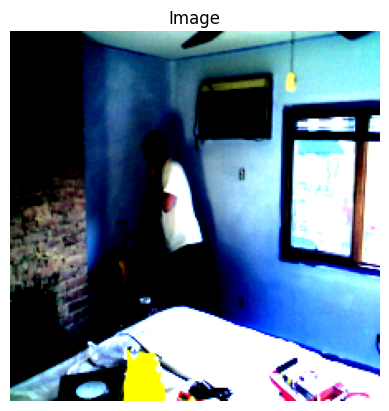

Original Caption: <START> man in his apartment bedroom answering his cell phone <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: picture of big kitchen counter with food decor <END>


LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/kaggle/working/nltk_data'
    - '/kaggle/working/nltk_data'
    - '/kaggle/working/nltk_data'
**********************************************************************

In [109]:
# Imports for additional metrics
import random
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.rouge.rouge import Rouge

# Initialize CIDEr scorer
cider_scorer = Cider()

# Initialize Rouge scorer
rouge_scorer = Rouge()

def sample_caption(image, max_length=30):
    model.eval()
    
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    features = model.convnet(image.unsqueeze(0).to(device))  # Get features from the image
    features = model.linear(features)  # Transform features to hidden size
    features = features.unsqueeze(0).repeat(num_layers, 1, 1)  # Add time dimension (1, 1, hidden_size)
    
    input_tokens = sos_token  # Start with <sos> token
    generated_caption = []
    
    for _ in range(max_length):
        input_embed = model.embedding(input_tokens)  # Embed the input tokens
        
        output, _ = model.lstm(input_embed, (features, torch.zeros_like(features)))
        
        output = model.blocks(output)
        
        output = model.fc_out(output)  # Output shape: (1, seq_length, vocab_size)
        
        probabilities = F.softmax(output[:, -1, :], dim=-1)
        
        next_token = torch.multinomial(probabilities, num_samples=1)
        
        generated_caption.append(itos[next_token.item()])
        
        input_tokens = torch.cat([input_tokens, next_token], dim=1)

        if next_token.item() == stoi['<END>'] or next_token.item() == stoi['<PAD>']:
            break
    
    return generated_caption

def calculate_scores(references, generated_caption):
    # Function to calculate BLEU, METEOR, CIDEr, and ROUGE scores
    smoothing_function = SmoothingFunction().method1
    
    # BLEU scores
    bleu_1 = sentence_bleu(references, generated_caption, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu_4 = sentence_bleu(references, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
    
    # METEOR score
    meteor = meteor_score(references, generated_caption)
    
    # CIDEr score
    cider_scores, _ = cider_scorer.compute_score({0: [' '.join(references[0])]}, {0: [' '.join(generated_caption)]})
    cider = cider_scores
    
    # ROUGE score
    rouge_scores = rouge_scorer.get_scores(' '.join(generated_caption), ' '.join(references[0]))
    rouge_1 = rouge_scores[0]['rouge-1']['f']
    rouge_l = rouge_scores[0]['rouge-l']['f']
    
    return {
        'BLEU-1': bleu_1,
        'BLEU-4': bleu_4,
        'METEOR': meteor,
        'CIDEr': cider,
        'ROUGE-1': rouge_1,
        'ROUGE-L': rouge_l
    }

def visualize_example(caption_dict, input_seq_dict, target_seq_dict, max_length, path):
    random_image = random.choice(list(caption_dict.keys()))
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    image_path = os.path.join(path, random_image)

    image_tensor = load_image(image_path, val_transform)
    image_array = image_tensor.permute(1, 2, 0).numpy()

    print(f"Random Image: {random_image}")
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()

    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)
    print(f"Original Caption: {original_caption}")

    references = [original_caption.split()]  # Tokenized reference caption

    for _ in range(5):
        generated_caption = sample_caption(image_tensor, max_length)
        print(f"Generated Caption: {' '.join(generated_caption)}")

        # Calculate scores
        scores = calculate_scores(references, generated_caption)
        
        # Print scores
        print(f"BLEU-1 Score: {scores['BLEU-1']:.4f}")
        print(f"BLEU-4 Score: {scores['BLEU-4']:.4f}")
        print(f"METEOR Score: {scores['METEOR']:.4f}")
        print(f"CIDEr Score: {scores['CIDEr']:.4f}")
        print(f"ROUGE-1 Score: {scores['ROUGE-1']:.4f}")
        print(f"ROUGE-L Score: {scores['ROUGE-L']:.4f}")

# Example usage
num_samples = 5
for _ in range(num_samples):
    visualize_example(val_captions, input_val_sequences, target_val_sequences, max_length, val_images_path)


In [112]:
import nltk
import zipfile

# Set the NLTK data path
nltk_data_path = '/kaggle/working/nltk_data'

# Add the NLTK data path
nltk.data.path.append(nltk_data_path)

# Check if WordNet can be accessed
from nltk.corpus import wordnet

syns = wordnet.synsets("program")
print(syns)


LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/kaggle/working/nltk_data'
    - '/kaggle/working/nltk_data'
    - '/kaggle/working/nltk_data'
    - '/kaggle/working/nltk_data'
    - '/kaggle/working/nltk_data'
**********************************************************************

Random Image: 000000025560.jpg


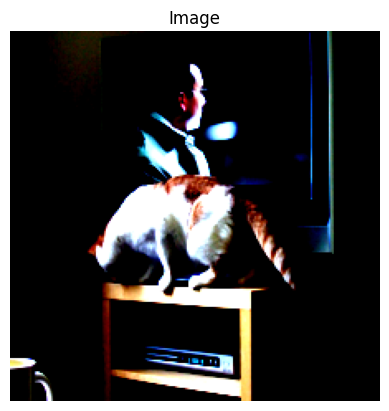

Original Caption: <START> cat perches on top of an entertainment center in front of tv <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: cat sitting on desk <END>
BLEU-1 Score: 0.0001
BLEU-4 Score: 0.0000
Random Image: 000000440475.jpg


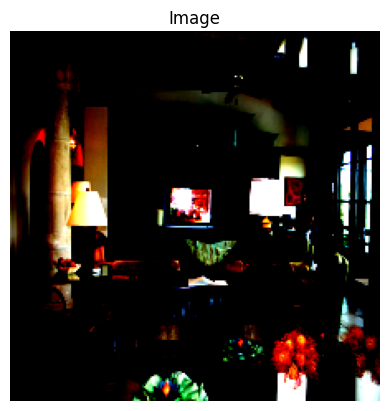

Original Caption: <START> living room with lot of chairs and big entertainment center <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: living room with furniture <END>
BLEU-1 Score: 0.0001
BLEU-4 Score: 0.0001
Random Image: 000000282046.jpg


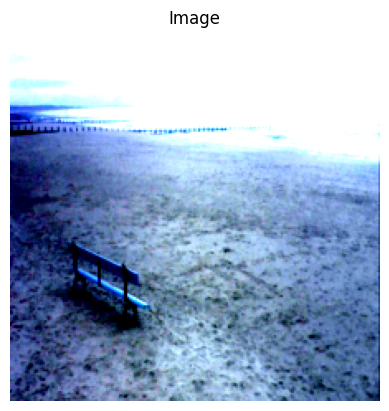

Original Caption: <START> bench sitting on the beach near the ocean <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: bench is shown <END>
BLEU-1 Score: 0.0000
BLEU-4 Score: 0.0000
Random Image: 000000468332.jpg


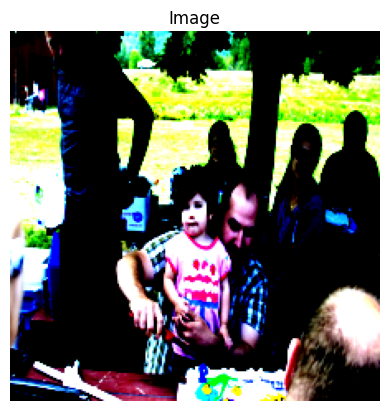

Original Caption: <START> man lighting candles on birthday cake for little girl <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: group of people standing around <END>
BLEU-1 Score: 0.0002
BLEU-4 Score: 0.0000
Random Image: 000000104119.jpg


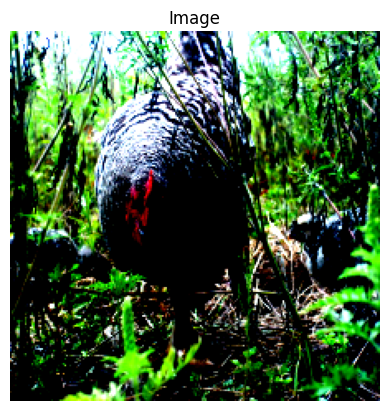

Original Caption: <START> bird in forest looking down towards the ground <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: herd of sheep <END>
BLEU-1 Score: 0.0000
BLEU-4 Score: 0.0000


In [56]:
# Beam search implementation
import heapq

def beam_search_caption(model, image, beam_width=10, max_length=30):
    model.eval()
    
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    features = model.convnet(image.unsqueeze(0).to(device))  # Get features from the image
    features = model.linear(features)  # Transform features to hidden size
    features = features.unsqueeze(0).repeat(num_layers, 1, 1)  # Add time dimension (1, 1, hidden_size)
    
    # Initialize the beam
    beam = [(0, sos_token, features, torch.zeros_like(features), [])]
    
    for _ in range(max_length):
        candidates = []
        
        for cumulative_score, tokens, h, c, caption in beam:
            if caption and caption[-1] in [stoi['<END>'], stoi['<PAD>']]:
                candidates.append((cumulative_score, tokens, h, c, caption))
                continue
            
            input_embed = model.embedding(tokens)
            output, (h_n, c_n) = model.lstm(input_embed, (h, c))
            output = model.blocks(output)
            output = model.fc_out(output)
            
            probabilities = F.log_softmax(output[:, -1, :], dim=-1)
            top_scores, top_indices = probabilities.topk(beam_width)
            
            for score, idx in zip(top_scores.squeeze(), top_indices.squeeze()):
                new_tokens = torch.cat([tokens, idx.unsqueeze(0).unsqueeze(0)], dim=1)
                new_caption = caption + [idx.item()]
                new_cumulative_score = cumulative_score + score.item()
                candidates.append((new_cumulative_score, new_tokens, h_n, c_n, new_caption))
        
        # Select top beam_width candidates
        beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])
        
        # Check if all beams have ended
        if all(caption[-1] in [stoi['<END>'], stoi['<PAD>']] for _, _, _, _, caption in beam):
            break
    
    # Return the caption with the highest score
    best_caption = max(beam, key=lambda x: x[0])[4]
    return [itos[token] for token in best_caption]

# Modify visualize_example to use beam_search_caption
def visualize_example(caption_dict, input_seq_dict, target_seq_dict, max_length, path):
    random_image = random.choice(list(caption_dict.keys()))
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    image_path = os.path.join(path, random_image)

    image_tensor = load_image(image_path, val_transform)
    image_array = image_tensor.permute(1, 2, 0).numpy()

    print(f"Random Image: {random_image}")
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)
    print(f"Original Caption: {original_caption}")
    
    references = [original_caption.split()]  # Tokenized reference caption
    smoothing_function = SmoothingFunction().method1
    
    generated_caption = beam_search_caption(model, image_tensor, beam_width=2, max_length=max_length)
    print(f"Generated Caption: {' '.join(generated_caption)}")
    
    # Calculate BLEU-1 and BLEU-4 scores
    bleu_1 = sentence_bleu(references, generated_caption, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu_4 = sentence_bleu(references, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
    
    print(f"BLEU-1 Score: {bleu_1:.4f}")
    print(f"BLEU-4 Score: {bleu_4:.4f}")

# Example usage remains the same
num_samples = 5
for _ in range(num_samples):
    visualize_example(val_captions, input_val_sequences, target_val_sequences, max_length, val_images_path)
# print("----")
# for _ in range(num_samples):
#     visualize_example(train_captions, train_input_sequences, train_target_sequences, max_length=max_length)

Activations:
layer 5 (      ReLU): mean +0.34, std 0.57, saturated: 7.60%
layer 7 (      ReLU): mean +0.55, std 1.18, saturated: 17.82%
layer 10 (      ReLU): mean +0.88, std 1.64, saturated: 28.85%
layer 12 (      ReLU): mean +0.91, std 2.35, saturated: 21.12%
layer 15 (      ReLU): mean +1.48, std 3.32, saturated: 28.23%
layer 17 (      ReLU): mean +1.58, std 3.70, saturated: 26.27%
layer 19 (      ReLU): mean +1.05, std 3.60, saturated: 14.43%
layer 22 (      ReLU): mean +1.32, std 3.94, saturated: 17.91%
layer 24 (      ReLU): mean +0.95, std 3.03, saturated: 14.93%
layer 26 (      ReLU): mean +0.39, std 1.78, saturated: 7.50%
layer 29 (      ReLU): mean +0.68, std 2.14, saturated: 14.30%
layer 31 (      ReLU): mean +0.47, std 1.57, saturated: 11.88%
layer 33 (      ReLU): mean +0.14, std 0.74, saturated: 4.26%
layer 38 (      ReLU): mean +0.34, std 0.85, saturated: 13.40%
layer 41 (      ReLU): mean +0.25, std 0.58, saturated: 9.97%
layer 56 (       ELU): mean +0.16, std 0.84, sat

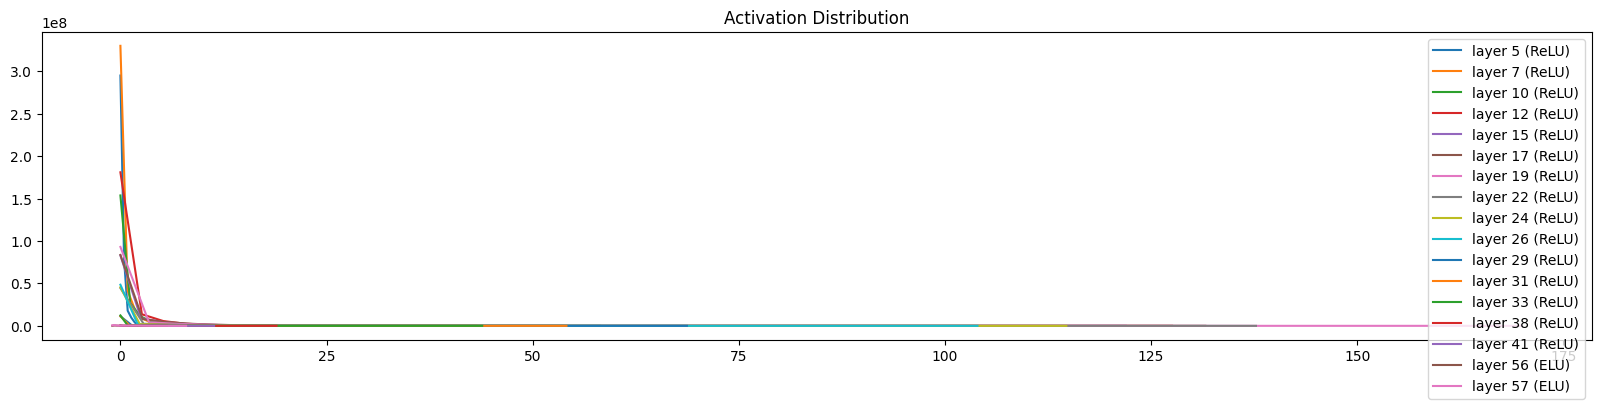

Gradients:
layer 37 (    Linear): mean -0.000040, std 4.183076e-04
layer 40 (    Linear): mean -0.000006, std 5.796895e-04
layer 45 (    Linear): mean -0.000006, std 5.108605e-04
layer 46 (    Linear): mean -0.000000, std 6.661257e-05
layer 47 ( Embedding): mean -0.000000, std 1.558121e-06
layer 51 ( LayerNorm): mean -0.000001, std 1.107452e-04
layer 52 (    Linear): mean -0.000000, std 1.300004e-04
layer 53 ( LayerNorm): mean -0.000011, std 7.406744e-05
layer 54 (    Linear): mean +0.000001, std 7.524445e-05
layer 55 (    Linear): mean +0.000001, std 7.729072e-05
layer 58 (    Linear): mean -0.000000, std 8.000780e-05


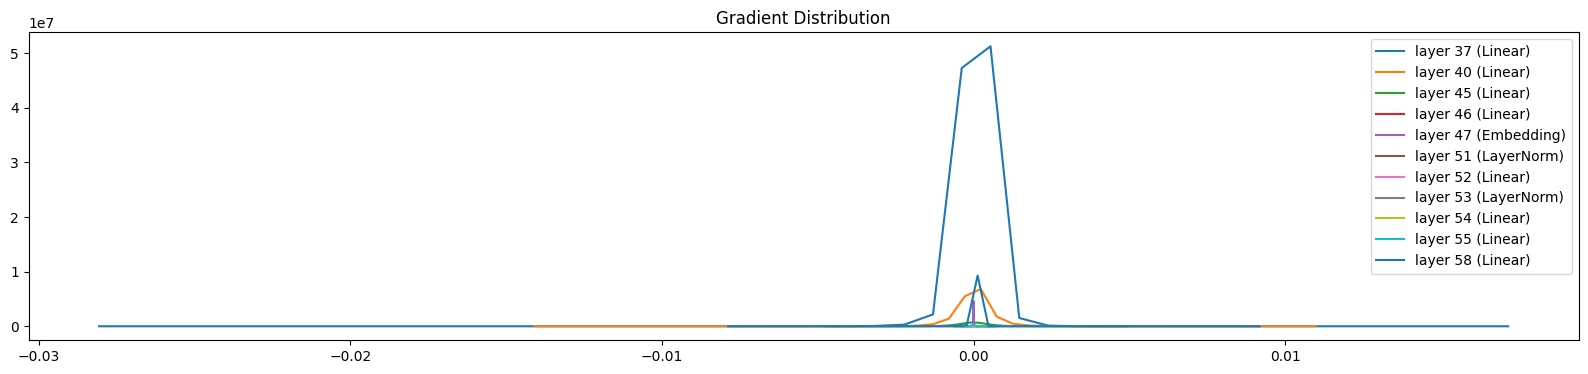

Weight gradients:
weight (4096, 25088) | mean -0.000040 | std 4.183076e-04 | grad:data ratio 8.294505e-02
weight (4096, 4096) | mean -0.000006 | std 5.796895e-04 | grad:data ratio 5.811178e-02
weight (1000, 4096) | mean -0.000006 | std 5.108605e-04 | grad:data ratio 2.766468e-02
weight (1024, 1000) | mean -0.000000 | std 6.661257e-05 | grad:data ratio 3.596510e-03
weight (9350, 512) | mean -0.000000 | std 1.558121e-06 | grad:data ratio 1.557657e-06
weight (4096, 512) | mean -0.000000 | std 1.033799e-04 | grad:data ratio 5.430058e-03
weight (4096, 1024) | mean +0.000000 | std 3.649918e-05 | grad:data ratio 1.954710e-03
weight (4096, 1024) | mean -0.000000 | std 6.783466e-05 | grad:data ratio 3.572116e-03
weight (4096, 1024) | mean -0.000000 | std 4.183341e-05 | grad:data ratio 2.268459e-03
weight (512, 1024) | mean -0.000000 | std 1.300004e-04 | grad:data ratio 7.129235e-03
weight (1024, 512) | mean +0.000001 | std 7.524445e-05 | grad:data ratio 2.824630e-03
weight (1024, 1024) | mean +

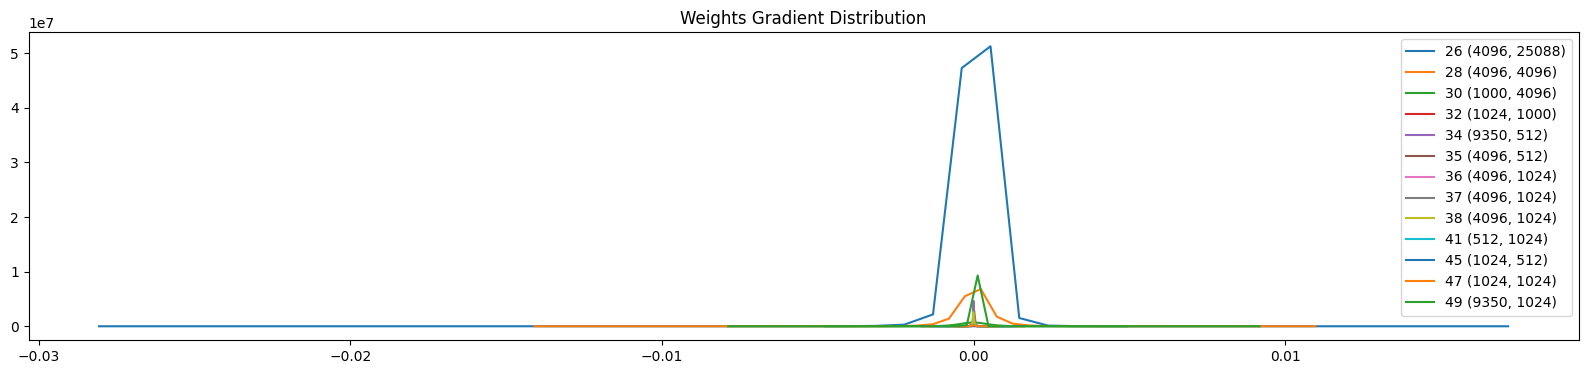

In [61]:
# # Function to register hooks for saving activations
# def register_hooks(layers):
#     for layer in layers:
#         if isinstance(layer, (nn.Tanh, nn.ReLU, nn.ELU)):
#             layer.register_forward_hook(lambda self, input, output: setattr(self, 'out', output))

# # Register hooks for the model
# register_hooks(list(model.modules()))

# Define a named function for the hook
def save_activations_hook(module, input, output):
    setattr(module, 'out', output)

# Modify register_hooks to use the named function
def register_hooks(layers):
    for layer in layers:
        if isinstance(layer, (nn.Tanh, nn.ReLU, nn.ELU)):
            layer.register_forward_hook(save_activations_hook)

# Register hooks for the model
register_hooks(list(model.modules()))


# Dummy forward pass
outputs = model(image_batch.to(device), caption_batch.to(device), memory.to(device))

# Visualize activations after a training iteration
def visualize_activations(model):
    plt.figure(figsize=(20, 4))
    print("Activations:")
    legends = []
    for i, layer in enumerate(model.modules()):
        if hasattr(layer, 'out'):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (t.abs() > 0.97).float().mean().item()*100))
            hy, hx = torch.histc(t, bins=50, min=t.min().item(), max=t.max().item()).cpu().numpy(), torch.linspace(t.min().item(), t.max().item(), steps=50).cpu().numpy()
            plt.plot(hx, hy)
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('Activation Distribution')
    plt.show()

# Visualize gradients after a training iteration
def visualize_gradients(model):
    plt.figure(figsize=(20, 4))
    print("Gradients:")
    legends = []
    for i, layer in enumerate(model.modules()):
        if hasattr(layer, 'weight') and layer.weight.grad is not None:
            t = layer.weight.grad
            print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean().item(), t.std().item()))
            hy, hx = torch.histc(t, bins=50, min=t.min().item(), max=t.max().item()).cpu().numpy(), torch.linspace(t.min().item(), t.max().item(), steps=50).cpu().numpy()
            plt.plot(hx, hy)
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('Gradient Distribution')
    plt.show()

# Visualize weights gradient distribution after a training iteration
def visualize_weights_gradient(model):
    plt.figure(figsize=(20, 4))
    print("Weight gradients:")
    legends = []
    for i, p in enumerate(model.parameters()):
        if p.grad is not None:
            t = p.grad
            if p.ndim == 2:
                print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean().item(), t.std().item(), t.std().item() / p.std().item()))
                hy, hx = torch.histc(t, bins=50, min=t.min().item(), max=t.max().item()).cpu().numpy(), torch.linspace(t.min().item(), t.max().item(), steps=50).cpu().numpy()
                plt.plot(hx, hy)
                legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('Weights Gradient Distribution')
    plt.show()

# After a training iteration, call these functions to visualize the statistics
visualize_activations(model)
visualize_gradients(model)
visualize_weights_gradient(model)
